## Initialization

In [1]:
pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
#Checking df shape.
print(labels.shape)

(7591, 2)


In [5]:
#Checking NaNs in df.
print(labels.isna().sum())

file_name    0
real_age     0
dtype: int64


In [6]:
#Checking duplicates in df.
print(labels.duplicated().sum())

0


## EDA

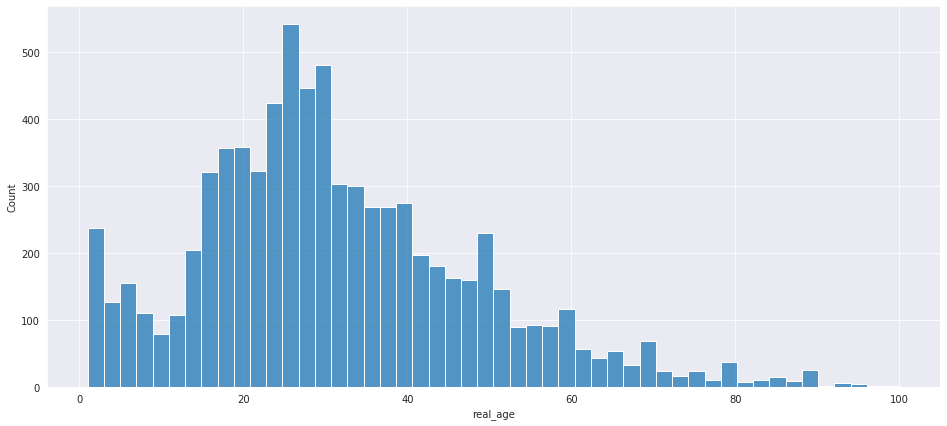

In [7]:
#Plotting an histogram of real_age column to understand age distribution in the df.
sns.set_style('darkgrid')
plt.figure(figsize=(16,7))
sns.histplot(labels['real_age'], bins = 50)
plt.show()

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


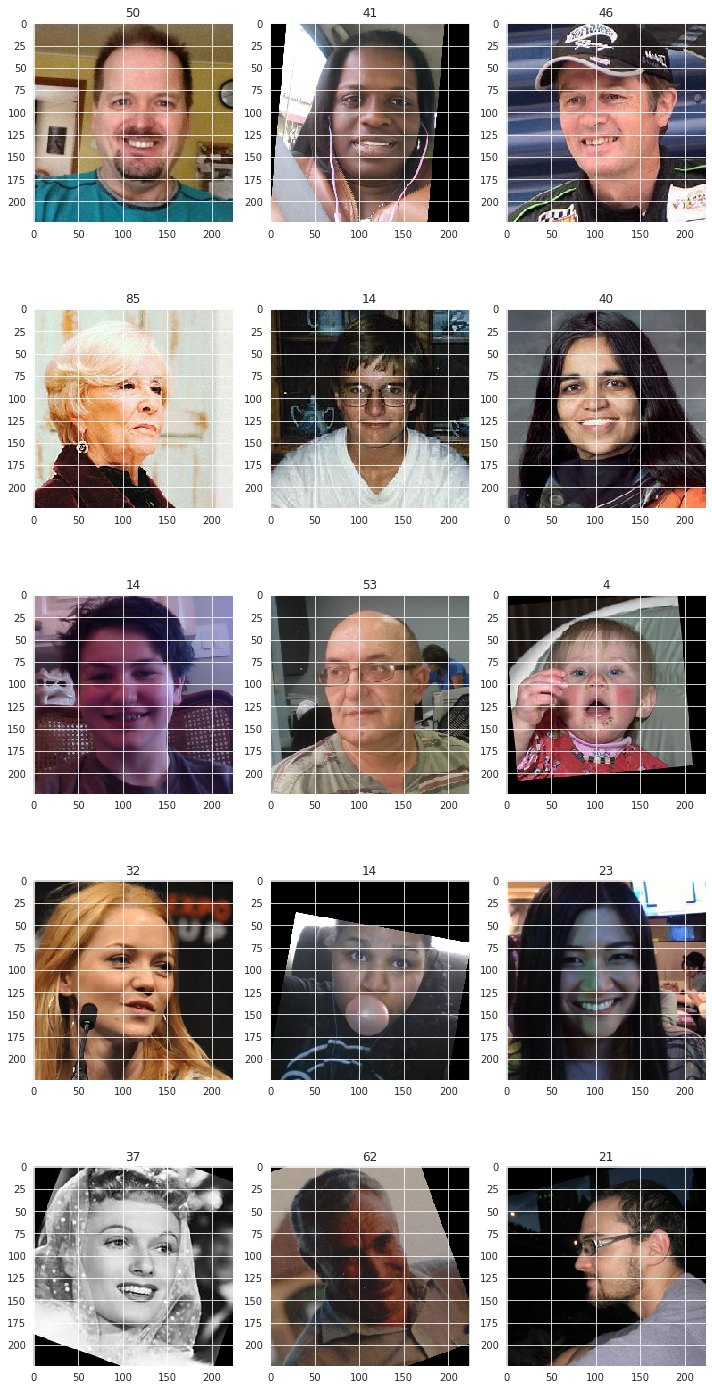

In [9]:
def show_batch(batch, predictions=None):
    fig = plt.figure(figsize=(10, 20))

    for i in range(15):
        fig.add_subplot(5, 3, i+1)
        plt.imshow(batch[0][i])
        title = batch[1][i]
        if predictions is not None:
            title = f'gt: {title}, pred: {round(predictions[i])}'
        plt.title(title)

    fig.tight_layout()

show_batch(next(gen_flow))

### Findings

- The type of the model is Regression.
- We need the final layer with only one neuron cause it has to return one single value as output. I am going to add it to the backbone of ResNet50 by adding a Dense layer.
- Since we don't need negative values to be computed I am going to use 'ReLu' activation to transform those values in zeros.
- The suitable loss function is 'MSE'.
- We can see that target has normal distribution.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [10]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [11]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [12]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [13]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [14]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [15]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

- The **goal** of this project was **to train a Neural Network to recognize the age of a person from photos**. 

- The model choosen was the backbone of a `ResNet50`, specified activation as `'relu'` to transform negative values into 0 and added a final layer with one neuron to return a single output obtained by the regression. 

- Loss function was `'mse'` the metric was 'mae'. 

- The choosen batch size was 16 and the learning r=0.001.
- The model is adequate to the proposed use case. Image data augmentation is perhaps the most well-known type of data augmentation and involves creating transformed versions of images in the training dataset that belong to the same class as the original image.